In [2]:
# Step 0: Install & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Example file names: historical_data.csv, fear_greed_index.csv
trader_data = pd.read_csv("/content/historical_data.csv")
sentiment_data = pd.read_csv("/content/fear_greed_index.csv")

In [4]:
trader_data.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [8]:
trader_data.count()

,0
Account,211224
Coin,211224
Execution Price,211224
Size Tokens,211224
Size USD,211224
Side,211224
Timestamp IST,211224
Start Position,211224
Direction,211224
Closed PnL,211224


In [7]:
sentiment_data.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [9]:
sentiment_data.count()

,0
timestamp,2644
value,2644
classification,2644
date,2644


In [4]:
# Step 2: Preprocess Timestamps
trader_data['Datetime'] = pd.to_datetime(trader_data['Timestamp'], unit='ms')
sentiment_data['Datetime'] = pd.to_datetime(sentiment_data['timestamp'], unit='s')
trader_data['Date'] = trader_data['Datetime'].dt.date
sentiment_data['Date'] = sentiment_data['Datetime'].dt.date

In [5]:
# Step 3: Merge on Date
merged_data = pd.merge(trader_data, sentiment_data[['Date', 'classification']], on='Date', how='left')

In [6]:
# Step 4: Compute Trader Performance Metrics
performance = merged_data.groupby(['Account', 'classification']).agg(
    total_trades=('Trade ID', 'count'),
    avg_pnl=('Closed PnL', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    win_rate=('Closed PnL', lambda x: np.mean(x > 0)),
    trading_days=('Date', pd.Series.nunique),
    avg_fee=('Fee', 'mean'),
    max_drawdown=('Closed PnL', 'min'),
    pnl_std=('Closed PnL', 'std')
).reset_index()

In [7]:
# Step 5: Compute Sharpe Ratio & Rank Traders
performance['sharpe_ratio'] = performance['avg_pnl'] / performance['pnl_std']
performance.replace([np.inf, -np.inf], np.nan, inplace=True)
performance['pnl_rank'] = performance.groupby('classification')['total_pnl'].rank(ascending=False)
performance['sharpe_rank'] = performance.groupby('classification')['sharpe_ratio'].rank(ascending=False)
performance.drop(columns=['pnl_std'], inplace=True)

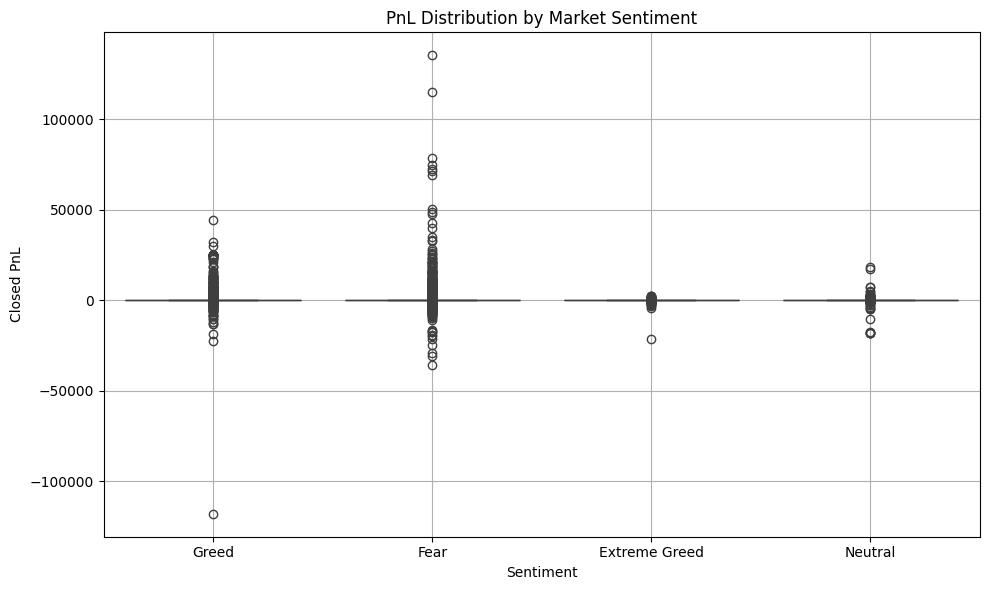

In [8]:
# Step 6: Visualize PnL by Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='classification', y='Closed PnL')
plt.title("PnL Distribution by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

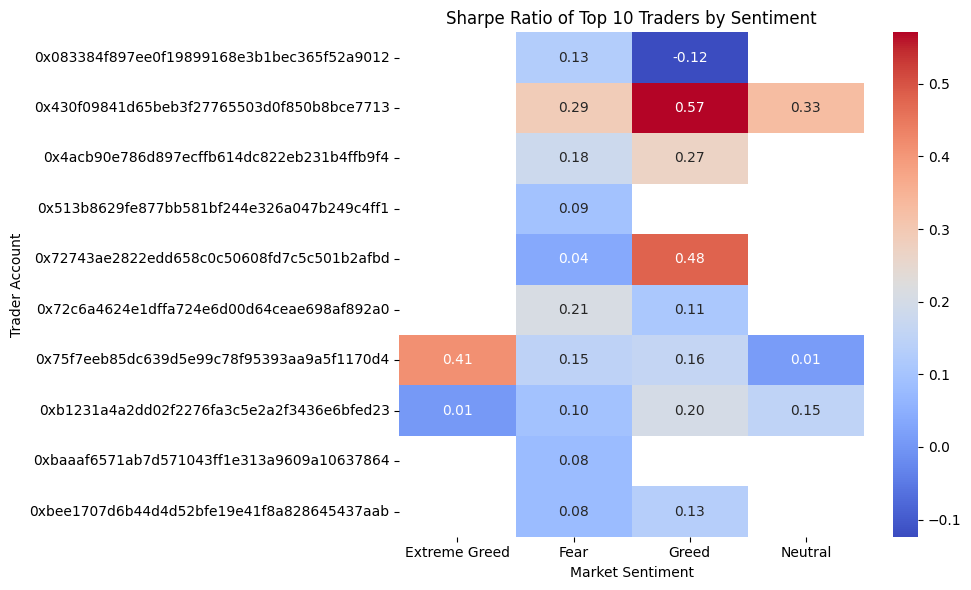

In [10]:
# Step 7: Heatmap - Sharpe Ratio of Top 10 Traders
top_traders = performance.groupby('Account')['total_pnl'].sum().nlargest(10).index
heatmap_data = performance[performance['Account'].isin(top_traders)].pivot(
    index='Account', columns='classification', values='sharpe_ratio'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Sharpe Ratio of Top 10 Traders by Sentiment")
plt.ylabel("Trader Account")
plt.xlabel("Market Sentiment")
plt.tight_layout()
plt.show()

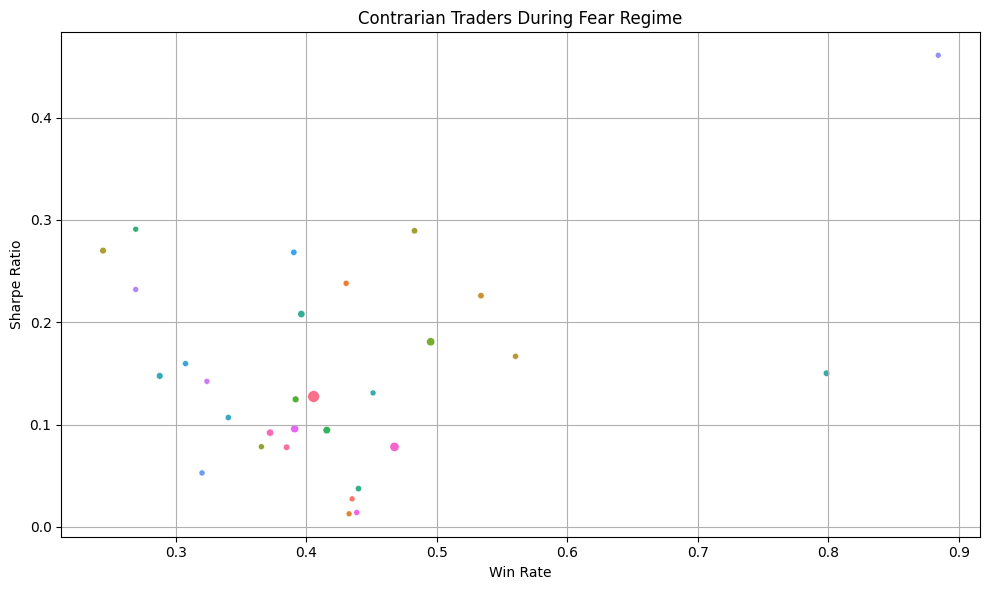

In [11]:
# Step 8: Contrarian Traders (High Sharpe in Fear)
contrarian_data = performance[(performance['classification'] == 'Fear') & (performance['sharpe_ratio'] > 0)]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=contrarian_data, x='win_rate', y='sharpe_ratio', size='total_pnl', hue='Account', legend=False)
plt.title("Contrarian Traders During Fear Regime")
plt.xlabel("Win Rate")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Step 9: Display Top 5 Contrarians
top_contrarians = contrarian_data.sort_values(by='sharpe_ratio', ascending=False).head(5)
print("Top Contrarian Traders in Fear Regime:")
print(top_contrarians[['Account', 'total_trades', 'avg_pnl', 'total_pnl', 'win_rate', 'sharpe_ratio']])

Top Contrarian Traders in Fear Regime:
                                       Account  total_trades     avg_pnl  \
57  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0            95  204.755184   
35  0x6d6a4b953f202f8df5bed40692e7fd865318264a           572   12.201645   
22  0x430f09841d65beb3f27765503d0f850b8bce7713           671  164.721171   
19  0x420ab45e0bd8863569a5efbb9c05d91f40624641           258  710.864435   
53  0x92f17e8d81a944691c10e753af1b1baae1a2cd0d          2080   48.318472   

        total_pnl  win_rate  sharpe_ratio  
57   19451.742477  0.884211      0.460910  
35    6979.340871  0.269231      0.290911  
22  110527.905862  0.482861      0.289349  
19  183403.024142  0.244186      0.269979  
53  100502.420808  0.390385      0.268307  


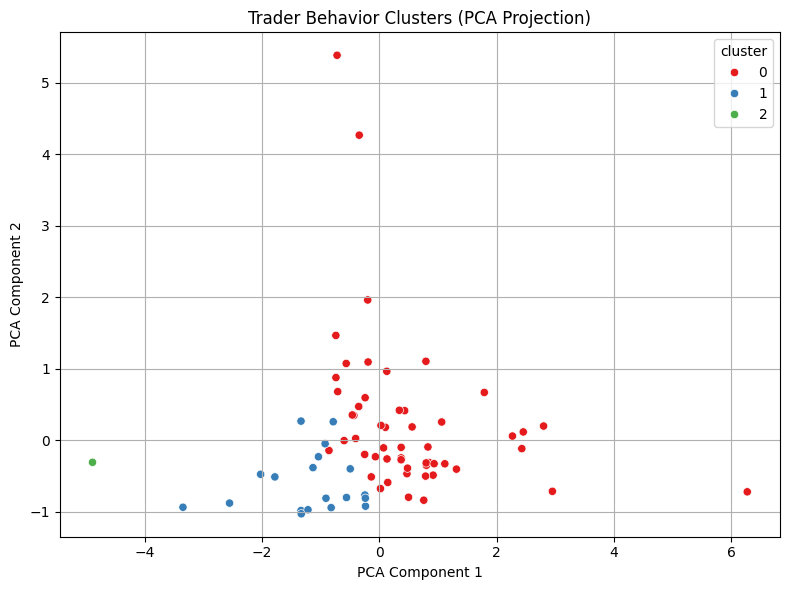

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 1: Select and scale features
cluster_data = performance[['total_trades', 'avg_pnl', 'win_rate', 'sharpe_ratio', 'max_drawdown']].fillna(0)
scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_data)

# Step 2: Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
performance['cluster'] = kmeans.fit_predict(scaled)

# Step 3: Visualize clusters using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=performance['cluster'], palette='Set1')
plt.title("Trader Behavior Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
